In [4]:
import uproot as ur
import matplotlib.pyplot as plt
import k3d
import numpy as np
import awkward as ak
import mplhep as hep
import matplotlib.colors as mcolors

In [6]:
#Open root file
input_file = 'rec_cal_output_50gev_3deg.edm4hep.root'
events = ur.open("%s:events"%(input_file))
arrays = events.arrays()

#gather arrays of reconstructed hits data
recoenergy = arrays['HcalEndcapPInsertHitsReco.energy']
recotime = arrays['HcalEndcapPInsertHitsReco.time']
recox = arrays['HcalEndcapPInsertHitsReco.position.x']
recoy = arrays['HcalEndcapPInsertHitsReco.position.y']
recoz = arrays['HcalEndcapPInsertHitsReco.position.z']

#Create 1D arrays for reconstructed hit data
RecoEventEnergies = []
RecoHitEnergies = []
RecoTimes = []
RecoXpos = []
RecoYpos = []
RecoZpos = []

#Gather arrays of generated primary particles
cut_primary = arrays["MCParticles.generatorStatus"]==1
px = arrays['MCParticles.momentum.x'][cut_primary]
py = arrays['MCParticles.momentum.y'][cut_primary]
pz = arrays['MCParticles.momentum.z'][cut_primary]
mass = arrays["MCParticles.mass"][cut_primary]

#Calculate generated primary particle properties
mom = np.sqrt(px**2+py**2+pz**2)
energy = np.sqrt(mom**2+mass**2)
fig = plt.figure( figsize=(8, 6))
phi = np.arctan2(py,px)

#Create 1D arrays for generated primary particles data
GenEnergies = []
Phis = []

#Create 1D arrays for other calculated variables
EnergyResolution = []


#Loop over all events
for i in range(len(recoenergy)):
    
    #Reset all calculated event-level calculations
    EventEnergy = 0
    
    #Loop over all hits within an event
    for j in range(len(recoenergy[i])):
        
        #Apply any hit-level cuts
        if recoenergy[i][j] < 1000 and recoenergy[i][j] > 0.0006 and recotime[i][j] < 200:
            
            #Sum all non-cut hit energies within an event to determine the reconstructed event energy
            EventEnergy += recoenergy[i][j]
            
            #Append hit data to 1D arrays
            RecoXpos.append(recox[i][j])
            RecoYpos.append(recoy[i][j])
            RecoZpos.append(recoz[i][j])
            RecoHitEnergies.append(recoenergy[i][j])
            RecoTimes.append(recotime[i][j])
            
            
    #Apply any event-level cuts    
    if EventEnergy > 0:    
        
        #Append event data to 1D arrays
        #If there are n primary generated particles per event,
        #array[i][0] will need to change to array[i][x] looping from x = 0 to x = n - 1
        EnergyResolution.append((EventEnergy- energy[i][0])/energy[i][0])
        GenEnergies.append(energy[i][0])
        Phis.append(phi[i][0])
        
    #Print progress
    if i % 100 == 0:
        print(i)


0
100
200
300
400
500
600
700
800
900


<Figure size 576x432 with 0 Axes>

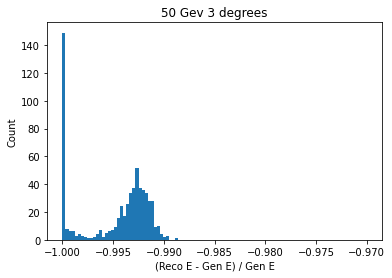

In [7]:
#Plot energy resolution histogram
plt.ylabel('Count')
plt.xlabel('(Reco E - Gen E) / Gen E')
plt.title('50 Gev 3 degrees')
plt.hist(EnergyResolution,bins=100, range=(-1,-0.97),label='HCAL')
plt.show()

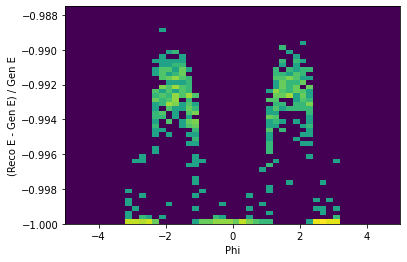

In [8]:
#Plot generated phi vs energy resolution
#Should be uniform if the generated particle is oriented correctly
plt.ylabel('(Reco E - Gen E) / Gen E')
plt.xlabel('Phi')
plt.hist2d(Phis,EnergyResolution,bins=50, range=([-5,5],[-1,-0.9875]),norm=mcolors.PowerNorm(0.2))
plt.show()

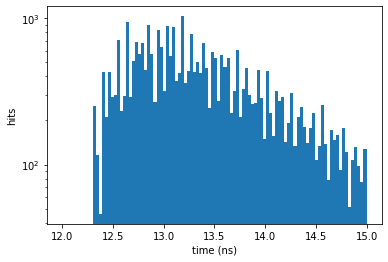

In [9]:
#Plot hit time histogram
plt.hist(RecoTimes,bins=100, range=(12,15),label='HCAL')
plt.yscale('log')
plt.xlabel('time (ns)')
plt.ylabel('hits')
plt.show()

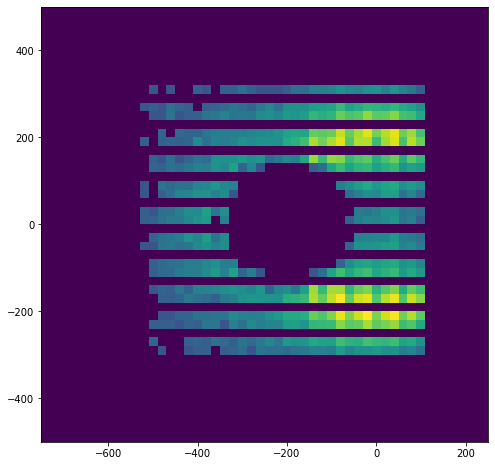

In [10]:
#Plot X Y hit distribution
fig = plt.figure( figsize=(8, 8))
plt.hist2d(RecoXpos,RecoYpos,bins=50, range=([-750,250],[-500,500]),norm=mcolors.PowerNorm(0.2))
plt.show()

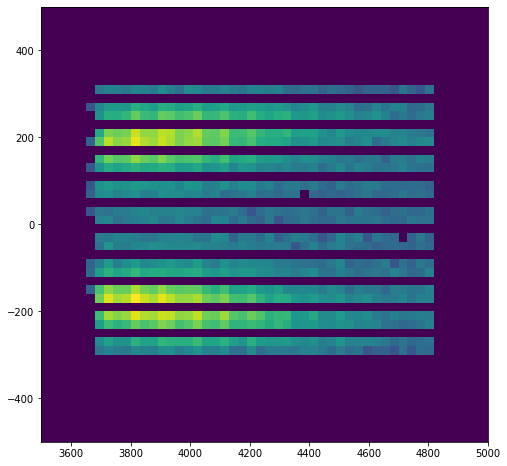

In [11]:
#Plot Z Y hit distribution
fig = plt.figure( figsize=(8, 8))
plt.hist2d(RecoZpos,RecoYpos,bins=50, range=([3500,5000],[-500,500]),norm=mcolors.PowerNorm(0.2))
plt.show()